In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import time

class Timer(object):##From py-faster-rcnn, RBGirshick, github
    """A simple timer."""
    def __init__(self):
        self.total_time = 0.
        self.calls = 0
        self.start_time = 0.
        self.diff = 0.
        self.average_time = 0.

    def tic(self):
        # using time.time instead of time.clock because time time.clock
        # does not normalize for multithreading
        self.start_time = time.time()

    def toc(self, average=True):
        self.diff = time.time() - self.start_time
        self.total_time += self.diff
        self.calls += 1
        self.average_time = self.total_time / self.calls
        if average:
            return self.average_time
        else:
            return self.diff
#Function to read pose data
def observe(file):
    with open(file,'r') as input:
#         poseData = np.asarray(json.load(input))
        poseData = json.load(input)
    return poseData

#function to output pose data in control file
def control(file,acc):
    with open(file,'w') as output:
        dicta = {'robot_0':acc}
        jsondata = json.dumps(dicta)
        output.write(jsondata)



In [2]:
#function to calculate angle of node(higher angle is a heuristic for minimum path)
def sine(node):
    return node[1]/(node[0]+1e-5)
#function sets up spacetime config for autocar by storing critical points of visibility graph
def configSpacetime(posedata,initpos,vfront,vrear,vhw,goal,buff):
    nodes = []
    agents = np.zeros((len(posedata.keys()),4))
    i=0
    for value in posedata:
        #print value
        enter = False
        exit = False
        for loc in posedata[value]:
            if(loc[2]==180 and loc[0]<=(initpos[0]+vhw+vfront) and not enter):
                nodes = nodes + [[loc[3],loc[1]+vhw+vrear+buff,i,1]]
                agents[i][0]=loc[3]
                agents[i][1]=loc[1]+vhw+vrear+buff
                enter = True
            if(loc[2]==180 and loc[0]<=(initpos[0]-vhw-vrear) and not exit):
                nodes = nodes + [[loc[3],loc[1]-vhw-vfront-buff,i,0]]
                agents[i][2]=loc[3]
                agents[i][3]=loc[1]-vhw-vfront-buff
                exit = True
            if(loc[2]==0 and loc[0]>=(initpos[0]-vhw-vfront) and not enter):
                nodes = nodes + [[loc[3],loc[1]+vhw+vrear+buff,i,1]]
                agents[i][0]=loc[3]
                agents[i][1]=loc[1]+vhw+vrear+buff
                enter = True
            if(loc[2]==0 and loc[0]>=(initpos[0]+vhw+vrear) and not exit):
                nodes = nodes + [[loc[3],loc[1]-vhw-vfront-buff,i,0]]
                agents[i][2]=loc[3]
                agents[i][3]=loc[1]-vhw-vfront-buff
                exit = True
        i=i+1
    nodes.sort(key = sine, reverse = True)
    return nodes,agents

In [3]:
#parametrized quantization to avoid collisions near corners
#if corner below, rounded up else rounded down
def quantize(value,node):
    if(node==1):
        return np.ceil(value*10)/10.0
    else:
        return np.floor(value*10)/10.0
#TO calculate if the lines p1-p2 and q1-q2 intersect
def intersect(p1,p2,q1,q2):
    cp1 = np.cross(p2-p1,q1-p2)
    cp2 = np.cross(p2-p1,q2-p2)
    cp3 = np.cross(q2-q1,p1-q2)
    cp4 = np.cross(q2-q1,p2-q2)
    if(np.dot(cp1,cp2)<0 and np.dot(cp3,cp4)<0):
        return True
    elif(np.dot(cp1,cp2)>0 or np.dot(cp1,cp2)>0):
        return False
    else:
        if(np.dot(p1-q1,p2-q1)<0 or np.dot(p1-q2,p2-q2)<0):
            return True
        else:
            return False
#To check if point goal is reachable from start without collisions
def reachable(start,goal,agents):
    reachable = True
    for node in agents:
        if(node[2]<=curpath[-1][0] or\
           (node[2]==goal[0]and node[3]==goal[1]) or (node[0]==goal[0]and node[1]==goal[1])):
            #specialize to goals below location later: or node[1]<curpath[-1][1]
            continue
        if(intersect(start,np.asarray(goal),np.asarray([node[0],node[1]]),np.asarray([node[0],node[3]])) or\
           intersect(start,np.asarray(goal),np.asarray([node[0],node[3]]),np.asarray([node[2],node[3]])) or\
           intersect(start,np.asarray(goal),np.asarray([node[2],node[3]]),np.asarray([node[2],node[1]])) or\
           intersect(start,np.asarray(goal),np.asarray([node[0],node[1]]),np.asarray([node[2],node[1]]))):
            reachable=False
            break;
    return reachable

#To calculate directpath to goal based on velocity and acceleration constraints and add to visibility graph
def directpath(curpath,end,nodes,posv):
    cdist = 0.5*(posv-curpath[-1][3])*(curpath[-1][3]+posv+1)*0.1
    ctime = (posv-curpath[-1][3])/10.0
    if(end-curpath[-1][1]>=cdist):
        goal = [curpath[-1][0]+quantize((ctime+(end-curpath[-1][1]-cdist)/posv),1),end]
    else:
        p = quantize((1+np.sqrt(1+ 4*(curpath[-1][3]**2 + curpath[-1][3] + 2*end)))/2.0,1)
        goal = [curpath[-1][0]+(p-curpath[-1][3])/10,end]  
    return goal
#Recursive planpath function that works similar to dijkstra since it explores nodes with higher angles first
#higher angles correspond to lower time to goal
def planpath(end,nodes,plans,curpath,negv,posv,agents):
    goal= directpath(curpath,end,nodes,posv)#Check if direct path to goal is reachable from current loc
    if(reachable(np.asarray([curpath[-1][0],curpath[-1][1]]),goal,agents)):
        curpath= np.append(curpath,[[goal[0],goal[1],-2,posv]],axis=0)#plans.add(curpath)
        return curpath
    #if goal not reachable, then search node list for shortest path    
    for node in nodes:
        #ignore nodes from the past or nodes belonging to the same vehicle
        if(node[0]<=curpath[-1][0] or node[2]==curpath[-1][2]):
            continue
#         if(node[1]<=curpath[-1][1]):
#             if(agents[node[2]])
#             node = [node[0]]
        #estimate required speed to get to node. round up for upper corners, round down for lower.
        reqspeed = quantize((node[1]-curpath[-1][1])/(node[0]-curpath[-1][0]),node[3])
        #correction factor to keep node outside obstacle boundary for better path calculation
        if(node[3]==1):
            corr = 1e-5
        else:
            corr = -1e-5
        #To reach the goal point, the vehicle needs to maintain its average speed at reqspeed.
        #The average speed can be seen as a sum of series where it both undershoots and overshoots to maintain avg
        if(2*(reqspeed-curpath[-1][3]-1)+1<=10*(node[0]-curpath[-1][0])\
           and 2*reqspeed - curpath[-1][3] + 1 >= negv and 2*reqspeed - curpath[-1][3] -1 <= posv):
            if(reachable(np.asarray([curpath[-1][0],curpath[-1][1]]),np.asarray([node[0],node[1]]),agents)):
                curpath =np.append(curpath,[[node[0]-corr,node[1]+corr,node[2],reqspeed]],axis=0)
                pathplan = planpath(end,nodes,plans,curpath,negv,posv,agents)
                if pathplan is None:
                    curpath = curpath[:-1]
                    continue
                else:
                    return pathplan

In [95]:
#PID controller to control trajectory of autocar along planned path
def controller(totalpath,amin,amax,vmin,vmax,t,v,k):
    
    n = 1
    av=v
    tv = 0
    p = 0
    i = 0
    d = 0
    s = 0.1
    c=0
    MSE=0
    y = np.asarray([totalpath[0,1]])#np.zeros(2+int(np.around(np.max(totalpath[:,0])/s)))+
    tc=0
    ac = []#np.zeros(2+int(np.around(np.max(totalpath[:,0])/s)))
    vc = v#np.zeros(2+int(np.around(np.max(totalpath[:,0])/s)))
    kp = k[0]#7.16#6.8#values calculated via gradient descent for minimum MSE
    kd = k[1]#-0.4#-1.2
    ki = k[2]#-1.12#-0.52
    c2=1
    while(y[c]<=np.max(totalpath[:,1])):
        goal = totalpath[n,:]
        ty= totalpath[n-1,1]+\
        (totalpath[n,1]-totalpath[n-1,1])*(t-s-totalpath[n-1,0])/(totalpath[n,0]-totalpath[n-1,0])
        tv = (totalpath[n,1]-totalpath[n-1,1])/(totalpath[n,0]-totalpath[n-1,0])
        #MSE = MSE+(tv-av)**2
        d = tv-av+ty-y[c] -p
        p = tv-av+ty-y[c]
        i=(i*c+p)/(c+1)
        out = kd*d + kp*p + ki*i
        a = min(max(amin,kd*d + kp*p + ki*i),amax)
        af = 0
        if(v==vmax):
            af=min(0,a)
        elif(v==vmin):
            af=max(0,a)
        else:
            af=a
        v= min(max(vmin,v + a*s),vmax)
        vc = np.append(vc,v)#c+1]=
        ##The ros controller doesn't seem to limit the max speed, so limiting it through code
        
        ac = np.append(ac,af)
        y=np.append(y,y[c] + v*s) 
        t = t+s
        tc = np.append(tc,t)
        av = (av*c2 + v)/(c2+1)
        c=c+1
        c2=c2+1

        if(y[c]>goal[1]):
            c2=1
            n = n+1 
    return ac,y,vc,tc

In [5]:
initpos = [100,5]
vfront = 1.98
vrear = 0.405
vhw = 0.6
goal = 27
nodes = []

# Case 1

('Time taken:', 0.0076329708099365234)
[[ 0.   5.  -1.   0. ]
 [ 4.6 27.  -2.   5. ]]
('Time taken:', 0.009256124496459961)
[[ 0.       5.      -1.       0.     ]
 [ 7.49999 22.60501 13.       2.4    ]
 [ 8.49999 27.      -2.       5.     ]]
('Time taken:', 0.004588127136230469)
[[ 0.   5.  -1.   0. ]
 [ 4.6 27.  -2.   5. ]]
('Time taken:', 0.006539106369018555)
[[ 0.   5.  -1.   0. ]
 [ 4.6 27.  -2.   5. ]]
('Time taken:', 0.01645183563232422)
[[ 0.       5.      -1.       0.     ]
 [ 3.30001 12.81999  5.       2.3    ]
 [ 6.20001 27.      -2.       5.     ]]
('Time taken:', 0.021982908248901367)
[[ 0.       5.      -1.       0.     ]
 [ 5.80001 12.81999  1.       1.3    ]
 [ 8.80001 27.      -2.       5.     ]]
('Time taken:', 0.015298843383789062)
[[ 0.       5.      -1.       0.     ]
 [ 3.30001 12.81999  5.       2.3    ]
 [ 6.20001 27.      -2.       5.     ]]
('Time taken:', 0.01184701919555664)
[[ 0.       5.      -1.       0.     ]
 [ 4.80001 18.81999 14.       2.8    ]
 [ 6.5

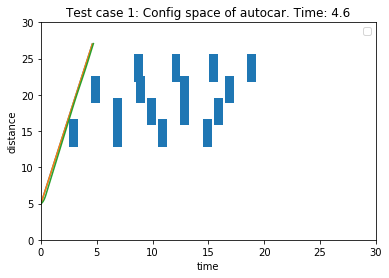

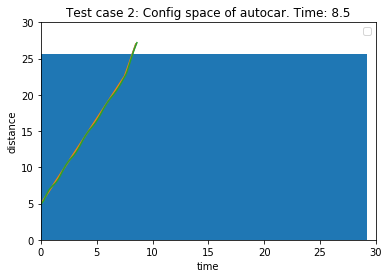

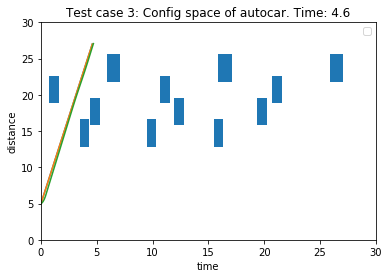

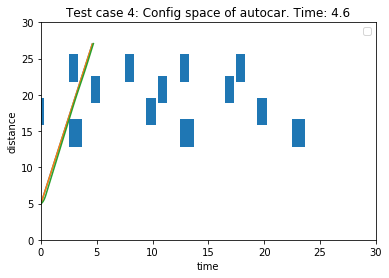

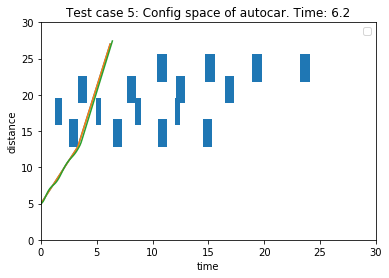

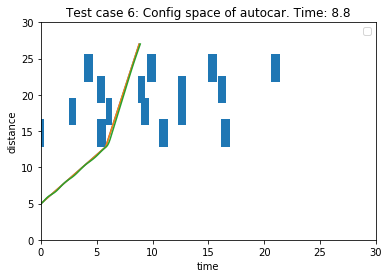

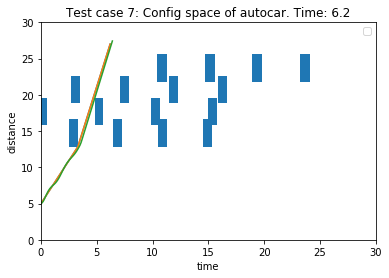

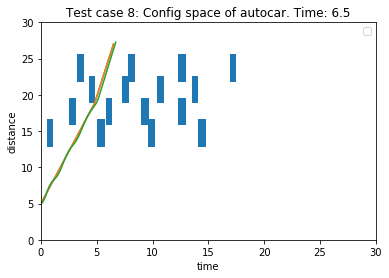

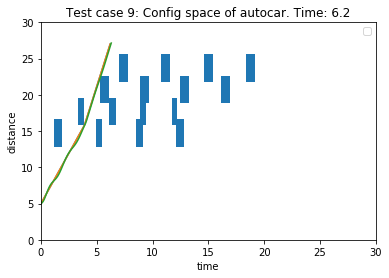

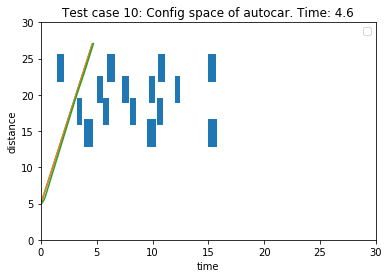

In [131]:
for tests in range(1,11):
    pose = observe("./scripts/highway/future_positions/test{}_poses.json".format(tests))
    nodes,agents = configSpacetime(pose,initpos,vfront,vrear,vhw,goal,0.1)
    nodes = np.asarray(nodes)

    curpath = np.asarray([[0,5,-1,0]])
    #print(curpath[-1][3])
    plans=[]
    negv=-5
    posv=5
    timer = Timer()
    timer.tic()
    totalpath = planpath(27,nodes,plans,curpath,negv,posv,agents)
    acc,path,_,tc = controller(totalpath,-10,10,-5,5,0,0,[ 9.5358348 ,  1.06911755, -1.61050681])#[5.51092845, 1.21123989, 0.56619629])
    timer.toc()
#     print(path)
#     print(_)
#     print(acc)
    print("Time taken:",timer.total_time)
    print(totalpath)
    fig,ax = plt.subplots()
    currentAxis = plt.gca()
    for i in agents:
        #print(i)
        currentAxis.add_patch(Rectangle((i[0],i[3]),i[2]-i[0],i[1]-i[3],alpha=1))
    plt.plot(totalpath[:,0],totalpath[:,1])
    plt.plot(totalpath[:,0],totalpath[:,1])
    #x=np.linspace(0,np.around(np.max(totalpath[:,0])+0.1,1),np.around(np.max(totalpath[:,0])*10)+2)
    plt.plot(tc,path)
    control("test{}_controls.json".format(tests),\
            [[acc[ind],float(str(tc[ind]))] for ind in range(len(acc))])
    plt.xlabel("time")
    plt.ylabel("distance")
    plt.xlim([0,30])
    plt.ylim([0,30])
    plt.title("Test case {}: Config space of autocar. Time: {}".\
              format(tests,np.around(np.max(totalpath[:,0]),1)))
    plt.legend()
    plt.savefig('path{}.png'.format(tests), dpi=300)

In [124]:
def ctrlMSE(totalpath,amin,amax,vmin,vmax,t,v,k):
    
    n = 1
    av=v
    tv = 0
    p = 0
    i = 0
    d = 0
    s = 0.1
    c=0
    MSE=0
    y = np.asarray([totalpath[0,1]])#np.zeros(2+int(np.around(np.max(totalpath[:,0])/s)))+
    tc=0
    ac = []#np.zeros(2+int(np.around(np.max(totalpath[:,0])/s)))
    vc = 0#np.zeros(2+int(np.around(np.max(totalpath[:,0])/s)))
    kp = k[0]#values calculated via gradient descent for minimum MSE
    kd = k[1]
    ki = k[2]
    c2=1
    while(y[c]<=np.max(totalpath[:,1]) and t<=np.max(totalpath[:,0])):
        goal = totalpath[n,:]
        ty= totalpath[n-1,1]+\
        (totalpath[n,1]-totalpath[n-1,1])*(t-s-totalpath[n-1,0])/(totalpath[n,0]-totalpath[n-1,0])
        tv = (totalpath[n,1]-totalpath[n-1,1])/(totalpath[n,0]-totalpath[n-1,0])
        MSE = (MSE*c+(tv-av+ty-y[c])**2)/(c+1)
        d = tv-av + ty-y[c] -p
        p = tv-av + ty-y[c]
        i=(i*c+p)/(c+1)
        out = kd*d + kp*p + ki*i
        a = min(max(amin,kd*d + kp*p + ki*i),amax)
        
        v= min(max(vmin,v + a*s),vmax)
        vc = np.append(vc,v)#c+1]=
        ##The ros controller doesn't seem to limit the max speed, so limiting it through code
        af = 0
#         if(v==vmax):
#             af=min(0,a)
#         elif(v==vmin):
#             af=max(0,a)
#         else:
#             af=a
        ac = np.append(ac,a)
        y=np.append(y,y[c] + v*s) 
        t = t+s
        tc = np.append(tc,t)
        av = (av*c2 + v)/(c2+1)
        c=c+1
        c2=c2+1

        if(y[c]>goal[1]):
            c2=1
            n = n+1 
    return MSE

In [129]:
k = np.asarray([6.8,-1.5,0.5])
grad = np.zeros(3)
eps = 1e-2
lr = 0.3
decay = 0.98
mom=0.9
niter=10000
for i in range(niter):
    k = k-(lr*grad)
    for j in range(3):
        k[j]=k[j]+eps
        errpos = ctrlMSE(totalpath,-10,10,-5,5,0,0,k)
        k[j]=k[j]-2*eps
        errneg = ctrlMSE(totalpath,-10,10,-5,5,0,0,k)
        k[j]=k[j]+eps
        grad[j]=mom*grad[j] + (errpos-errneg)/(2*eps)
        #print(grad[j])
        #k[j]=k[j]-(lr*grad[j])
    if(i%100==0):
        lr = lr*decay
        print(i,ctrlMSE(totalpath,-10,10,-5,5,0,0,k),k,lr)   
        #2300, 0.43229745392830177, array([ 7.16418979, -0.40234028, -1.11794038]), 0.018473410095272348)
        #0.4203085099926087, array([5.74321803, 0.95743683, 0.28276554]), 0.013103591
        #0.41890981197094057, array([5.51092845, 1.21123989, 0.56619629]), 0.05238831403348924)
        #9900, 2.3396292771135383, array([ 5.84093544, -0.1753937 , -0.22811763]), 0.039785866768425916)
        #6400, 0.38986293367926894, array([ 9.5358348 ,  1.06911755, -1.61050681]), 0.0806893421497817)


(0, 1.15615604749049, array([ 6.8, -1.5,  0.5]), 0.294)
(100, 0.3904290328069889, array([ 9.52936909,  1.69883801, -1.2889951 ]), 0.28812)
(200, 0.39002676325965896, array([ 9.52046359,  1.40230045, -1.45277182]), 0.2823576)
(300, 0.38990785496935326, array([ 9.52816123,  1.23353085, -1.5302878 ]), 0.276710448)
(400, 0.3898745946072558, array([ 9.53236166,  1.14560021, -1.57179529]), 0.27117623904)
(500, 0.38986575201332063, array([ 9.53457442,  1.10083634, -1.59320989]), 0.2657527142592)
(600, 0.3898634583078655, array([ 9.53571352,  1.0786499 , -1.60408468]), 0.26043765997401597)
(700, 0.3898630571812984, array([ 9.5359698 ,  1.07216968, -1.60845343]), 0.25522890677453564)
(800, 0.389862969666677, array([ 9.53587931,  1.07012488, -1.60982823]), 0.25012432863904493)
(900, 0.38986294533155147, array([ 9.53584986,  1.06945842, -1.61027719]), 0.24512184206626403)
(1000, 0.38986293765822405, array([ 9.53584002,  1.06923573, -1.6104272 ]), 0.24021940522493873)
(1100, 0.3898629350845306, ar

KeyboardInterrupt: 

# Case 2

('Time taken:', 1.7275819778442383)
('Time taken:', 1.0209572315216064)
('Time taken:', 0.5664267539978027)
('Time taken:', 1.1760621070861816)
('Time taken:', 0.8785345554351807)
('Time taken:', 1.1215670108795166)
('Time taken:', 0.7934093475341797)
('Time taken:', 1.3209683895111084)
('Time taken:', 4.6858110427856445)
('Time taken:', 7.144753694534302)


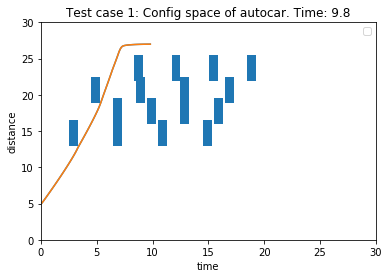

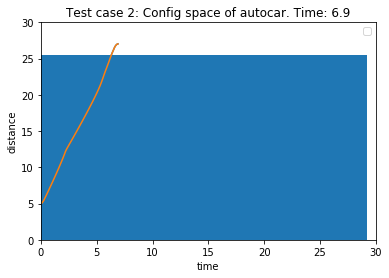

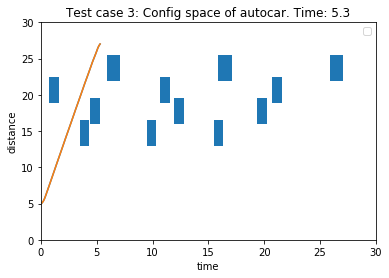

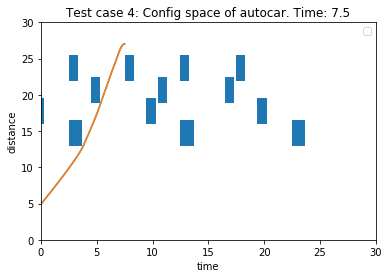

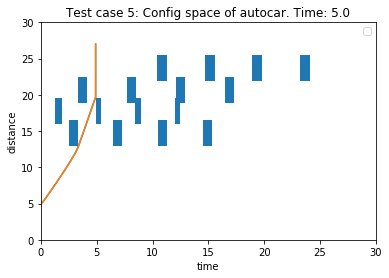

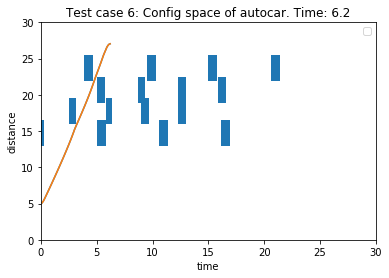

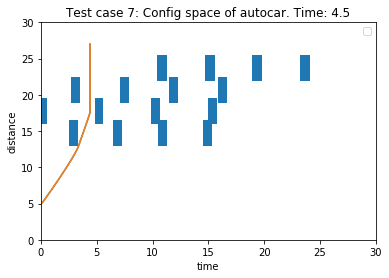

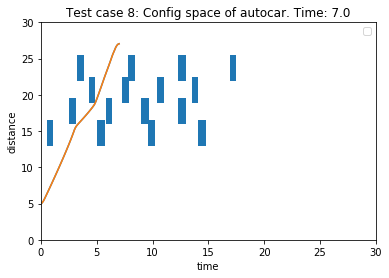

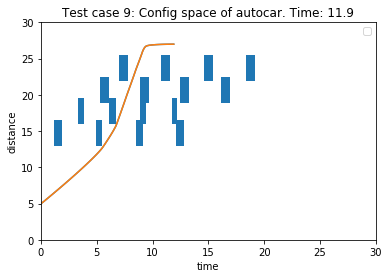

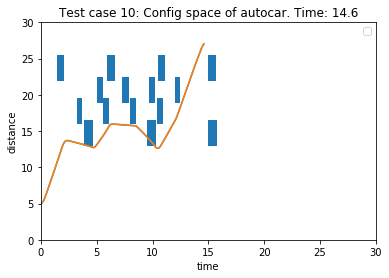

In [132]:
for tests in range(1,11):
    pose = observe("./scripts/highway/future_positions/test{}_poses.json".format(tests))
    t = 0
    step=0.1
    estimv = dict()
    curpath = np.asarray([[0,5,-1,0]])
    acceleration = list()
    y=list()
    td=list()
    reached = False
    timer = Timer()
    while(reached==False):

        timer.tic()
        for j in pose.keys():
            if(t>=len(pose[j])):
               pose.pop(j,None)#removing cars which are out of map
               continue
            estimv[j] = (pose[j][int(t)][0]-pose[j][int(t-1)][0])
        estipose=dict()
        for j in pose.keys():#generating pose values using constant speed estimate
            estipose[str(j)]=[[pose[j][int(t)][0]+estimv[j]*(n-t),pose[j][int(t)][1],pose[j][int(t)][2],n*step]\
                         for n in range(int(t),int(np.around(np.max(np.asarray(pose[j])[:,3])/step)))]
            #print(estipose)
        nodes,agents = configSpacetime(estipose,initpos,vfront,vrear,vhw,goal,0.2)
        #generated spacetime graph based on estimated poses every step
        nodes = np.asarray(nodes)
        plans=[]
        negv=-5
        posv=5
        #generate plan for every step from current position and updated pose map
        totalpath = planpath(27,nodes,plans,curpath,negv,posv,agents)
        #print(totalpath)
        if(not totalpath is None):
            acc,path,v,tc = controller(totalpath,-10,10,-5,5,t*step,curpath[-1][3],[5.51092845, 1.21123989, 0.56619629])
        else:
            path[1]=27
        t=t+1
        curpath = np.asarray([[(t)*step,path[1],-1,v[1]]])#may pick same vehicle
        acceleration.append(acc[0])
        y.append(path[1])
        td.append(tc[1])
        timer.toc()
        if(path[1]>=26.99):
            reached=True
            break
        
    print("Time taken:",timer.total_time)
    pose = observe("./scripts/highway/future_positions/test{}_poses.json".format(tests))
    nodes,agents = configSpacetime(pose,initpos,vfront,vrear,vhw,goal,0)
    curpath = np.asarray([[0,5,-1,0]])
    totalpath = planpath(27,nodes,plans,curpath,negv,posv,agents)
    fig,ax = plt.subplots()
    currentAxis = plt.gca()
    for i in agents:
        #print(i)
        currentAxis.add_patch(Rectangle((i[0],i[3]),i[2]-i[0],i[1]-i[3],alpha=1))
   # x=np.linspace(0,np.around(t*step,1),t+1)[:-2]
    #print(y)
    plt.plot(td,y)
    plt.plot(td,y)
    control("test{}_controls_online.json".format(tests),\
            [[acceleration[ind],float(str(td[ind]))] for ind in range(len(acceleration))])
    plt.xlabel("time")
    plt.ylabel("distance")
    plt.xlim([0,30])
    plt.ylim([0,30])
    plt.title("Test case {}: Config space of autocar. Time: {}".\
              format(tests,t*step))
    plt.legend()

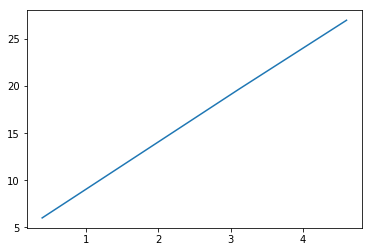

In [117]:
plt.plot([0.4,3.12,4.6],[6,19.7,27])

In [119]:
p3 = np.asarray([4.6,27])
p2 = np.asarray([3.12,19.705])
p1 = np.asarray([0.4,6])
slope = (p3-p1)[1]/(p3-p1)[0]
print(slope)
slope2 = (p2-p1)[1]/(p2-p1)[0]
print(slope2)

5.000000000000001
5.038602941176469


In [4]:
p1 = np.asarray([20,30,-1])
p2 = np.asarray([20,30,2])
q1 = np.asarray([1,1,0])
q2 = np.asarray([-1,1,0])
q3 = np.asarray([0,-1,0])
q4 = np.asarray([-2,-1,0])

In [7]:
print(inside(np.zeros(3),q1,q2,q3))

True


In [10]:
print(inside(p2,q1,q2,q3))

False


In [6]:
def inside(p1,q1,q2,q3):
    c1 = np.cross(q1-q2,p1-q1)
    c2 = np.cross(q3-q1,p1-q3)
    c3 = np.cross(q2-q3,p1-q2)
    if(np.dot(c1,c2)<0 or np.dot(c2,c3)<0):
        #If any of these change direction, we can be sure point is outside
        return False
    
    #If they're zero, they may be on the line outside or inside.
    if(np.linalg.norm(c1)==0):#If p1 is on the line q1 q2.
        if(np.dot(q1-q2,p1-q1)>0 or np.linalg.norm(p1-q1)>np.linalg.norm(q1-q2)):
            return True#print("Out")#considering on the line as outside due to buffers
        else:
            return True#print("in")
    if(np.linalg.norm(c2)==0):
        if(np.dot(q3-q1,p1-q3)>0 or np.linalg.norm(p1-q3)>np.linalg.norm(q3-q1)):
            return True#print("Out")
        else:
            return True#print("in")
    if(np.linalg.norm(c3)==0):
        if(np.dot(q2-q3,p1-q2)>0 or np.linalg.norm(p1-q2)>np.linalg.norm(q2-q3)):
            return True#print("Out")
        else:
            return True#print("in")
    return True

In [11]:
def intersectface(p1,p2,q1,q2,q3,q4):
    plane = np.cross(q1-q2,q3-q1)
    plane = plane/np.linalg.norm(plane)
    d = np.dot(q1,plane)
    intersect = np.dot(plane,p2-p1)
    if(intersect==0):
        return False#Parallel to plane or on the plane
    if((np.dot(p1,plane)-d)*(np.dot(p2,plane)-d)>0):
        return False#line segment lies on one side of the plane
    #calculate the lambda value to scale p1,p2 to get intersection point.(intersection lies inside linesegment)
    lam = (d - np.dot(p2,plane))/(np.dot(p1,plane)-np.dot(p2,plane))
    #print(lam*p1+(1-lam)*p2)
    return inside(lam*p1+(1-lam)*p2,q1,q2,q3) or inside(lam*p1+(1-lam)*p2,q2,q3,q4)

In [12]:
print(intersectface(p1,p2,q1,q2,q3,q4))

False


In [39]:
pose = observe("./scripts/highway/testoutput.json")

pose['robot_8']

In [131]:
initpos = [100,5]
vfront = 1.98
vrear = 0.405
vhw = 0.6
goal = 27
buff = 0.1
nodes = []

In [152]:
def configSpacetime3D(posedata,initpos,vfront,vrear,vhw,goal,buff):
    nodes = []
    agents = np.zeros((len(posedata.keys()),10))
    i=0
    for value in posedata:
        agents[i][0]=posedata[value][0][0]-vrear-vfront-buff#back point
        agents[i][1]=posedata[value][0][1]-vhw-vhw-buff#bottom point
        agents[i][2]=posedata[value][0][3]#start time
        agents[i][3]=posedata[value][0][0]+vrear+vfront+buff#front point
        agents[i][4]=posedata[value][0][1]+vhw+vhw+buff#top point
        agents[i][5]=posedata[value][-1][0]-vrear-vfront-buff#back point
        agents[i][6]=posedata[value][-1][1]-vhw-vhw-buff#bottom point
        agents[i][7]=posedata[value][-1][3]#end time
        agents[i][8]=posedata[value][-1][0]+vrear+vfront+buff#front point
        agents[i][9]=posedata[value][-1][1]+vhw+vhw+buff#top point
        i=i+1
    agents = agents[(-agents[:,0]).argsort()]#Sorting according to back point.
    #May change if cars in reverse direction
    return agents
def eightpoints(v):
    return np.asarray([v[0],v[1],v[2]]),np.asarray([v[3],v[1],v[2]]),np.asarray([v[0],v[4],v[2]]),\
np.asarray([v[3],v[4],v[2]]),np.asarray([v[5],v[6],v[7]]),np.asarray([v[8],v[6],v[7]]),\
np.asarray([v[5],v[9],v[7]]),np.asarray([v[8],v[9],v[7]])

In [137]:
agents = configSpacetime3D(pose,initpos,vfront,vrear,vhw,goal,buff)

In [143]:
print(len(agents))
print(agents[0])
node=agents[0]

q1,q2,q3,q4,q5,q6,q7,q8 = eightpoints(node)
print(intersectface(np.asarray([40,18,0]),np.asarray([104,18,29.9]),q1,q2,q3,q4))
print(intersectface(np.asarray([40,18,0]),np.asarray([104,18,29.9]),q1,q3,q5,q7))

8
[ 42.515  17.2     0.     47.485  19.8   102.315  17.2    29.9   107.285
  19.8  ]
[40. 18.  0.]
False
[78.32380952 18.         17.90440476]
True


In [149]:
#To check if point goal is reachable from start without collisions
def reachable(start,goal,agents):
    reachable = True
    for node in agents:
        q1,q2,q3,q4,q5,q6,q7,q8 = eightpoints(node)#Eightpoints defining occupancy of cspace by vehicle
        if(intersectface(start,goal,q1,q3,q5,q7) or#behindface\
           intersectface(start,goal,q1,q2,q5,q6) or#bottomface\
           intersectface(start,goal,q2,q4,q6,q8) or#frontface#not needed usually\
           intersectface(start,goal,q3,q4,q7,q8)):#topface
            reachable=False
            break;
    return reachable

In [ ]:
def reachable2(start,goal,vl,al,svl,sal):# forward and sideways acceleration and velocity limits.
    

In [147]:
#To calculate directpath to goal based on velocity and acceleration constraints and add to visibility graph
def directpath(curpath,end,nodes,vl,al,svl,sal,dt):
    curvf=curpath[-1][3]
    curvs=curpath[-1][4]
    cdist = 0.5*(vl-curvf)*(2*curvf+(vl-curvf)/(al*dt)+2*al*dt-1)/al
    #critical distance required to change velocity to max forward
    ctime = (vl-curvf)/al#criticaltime required to change velocity to max forward
    cdists = 0.5*np.abs(0-curvs)*(2*curvs+np.abs(0-curvs)/(al*dt)+2*sal*dt-1)/sal
    ctimes = np.abs(0-curvs)/sal#criticaltime required to nullify sideways velocity
    if(end-curpath[-1][1]>=cdist):
        goal = np.asarray([end,curpath[-1][1]+cdists,\
                           curpath[-1][2]+quantize((ctime+(end-curpath[-1][0]-cdist)/vl),1)])
    else:#
        print("Else case not worked on")
        p = quantize((1+np.sqrt(1+ 4*(curpath[-1][3]**2 + curpath[-1][3] + 2*end)))/2.0,1)
        goal = [curpath[-1][0]+(p-curpath[-1][3])/10,end]  
    return goal

In [ ]:
#Recursive planpath function that works similar to dijkstra since it explores nodes with higher angles first
#higher angles correspond to lower time to goal
def planpath(end,plans,curpath,lvl,vl,al,svl,sal,dt,agents):
    goal= directpath(curpath,end,agents,vl,al,svl,sal,dt)#Check if direct path to goal is reachable from current loc
    if(reachable(np.asarray([curpath[-1][0],curpath[-1][1],curpath[-1][2]]),goal,agents)):
        curpath= np.append(curpath,[[goal[0],goal[1],-2,posv]],axis=0)#plans.add(curpath)
        return curpath
    #if goal not reachable, then search node list for shortest path    
    for node in agents:
        #ignore nodes from the past or nodes belonging to the same vehicle
        #if(node[0]<=curpath[-1][0] or node[2]==curpath[-1][2]):
            #continue
#         if(node[1]<=curpath[-1][1]):
#             if(agents[node[2]])
#             node = [node[0]]
        #estimate required speed to get to node. round up for upper corners, round down for lower.
        reqspeed = quantize((node[1]-curpath[-1][1])/(node[0]-curpath[-1][0]),node[3])
        #correction factor to keep node outside obstacle boundary for better path calculation
        if(node[3]==1):
            corr = 1e-5
        else:
            corr = -1e-5
        #To reach the goal point, the vehicle needs to maintain its average speed at reqspeed.
        #The average speed can be seen as a sum of series where it both undershoots and overshoots to maintain avg
        if(2*(reqspeed-curpath[-1][3]-1)+1<=10*(node[0]-curpath[-1][0])\
           and 2*reqspeed - curpath[-1][3] + 1 >= negv and 2*reqspeed - curpath[-1][3] -1 <= posv):
            if(reachable(np.asarray([curpath[-1][0],curpath[-1][1]]),np.asarray([node[0],node[1]]),agents)):
                curpath =np.append(curpath,[[node[0]-corr,node[1]+corr,node[2],reqspeed]],axis=0)
                pathplan = planpath(end,nodes,plans,curpath,negv,posv,agents)
                if pathplan is None:
                    curpath = curpath[:-1]
                    continue
                else:
                    return pathplan

In [ ]:


#To calculate directpath to goal based on velocity and acceleration constraints and add to visibility graph
def directpath(curpath,end,nodes,posv):
    cdist = 0.5*(posv-curpath[-1][3])*(curpath[-1][3]+posv+1)*0.1
    ctime = (posv-curpath[-1][3])/10.0
    if(end-curpath[-1][1]>=cdist):
        goal = [curpath[-1][0]+quantize((ctime+(end-curpath[-1][1]-cdist)/posv),1),end]
    else:
        p = quantize((1+np.sqrt(1+ 4*(curpath[-1][3]**2 + curpath[-1][3] + 2*end)))/2.0,1)
        goal = [curpath[-1][0]+(p-curpath[-1][3])/10,end]  
    return goal
#Recursive planpath function that works similar to dijkstra since it explores nodes with higher angles first
#higher angles correspond to lower time to goal
def planpath(end,nodes,plans,curpath,negv,posv,agents):
    goal= directpath(curpath,end,nodes,posv)#Check if direct path to goal is reachable from current loc
    if(reachable(np.asarray([curpath[-1][0],curpath[-1][1]]),goal,agents)):
        curpath= np.append(curpath,[[goal[0],goal[1],-2,posv]],axis=0)#plans.add(curpath)
        return curpath
    #if goal not reachable, then search node list for shortest path    
    for node in nodes:
        #ignore nodes from the past or nodes belonging to the same vehicle
        if(node[0]<=curpath[-1][0] or node[2]==curpath[-1][2]):
            continue
#         if(node[1]<=curpath[-1][1]):
#             if(agents[node[2]])
#             node = [node[0]]
        #estimate required speed to get to node. round up for upper corners, round down for lower.
        reqspeed = quantize((node[1]-curpath[-1][1])/(node[0]-curpath[-1][0]),node[3])
        #correction factor to keep node outside obstacle boundary for better path calculation
        if(node[3]==1):
            corr = 1e-5
        else:
            corr = -1e-5
        #To reach the goal point, the vehicle needs to maintain its average speed at reqspeed.
        #The average speed can be seen as a sum of series where it both undershoots and overshoots to maintain avg
        if(2*(reqspeed-curpath[-1][3]-1)+1<=10*(node[0]-curpath[-1][0])\
           and 2*reqspeed - curpath[-1][3] + 1 >= negv and 2*reqspeed - curpath[-1][3] -1 <= posv):
            if(reachable(np.asarray([curpath[-1][0],curpath[-1][1]]),np.asarray([node[0],node[1]]),agents)):
                curpath =np.append(curpath,[[node[0]-corr,node[1]+corr,node[2],reqspeed]],axis=0)
                pathplan = planpath(end,nodes,plans,curpath,negv,posv,agents)
                if pathplan is None:
                    curpath = curpath[:-1]
                    continue
                else:
                    return pathplan

In [92]:
#def testbarycentric(p1,q1,q2,q3):
T = np.vstack((q1,q2,q3)).T
lam = np.matmul(np.linalg.pinv(T),p1)#is this valid math? is this optimal?
print(lam)

def intersectface(p1,p2,q1,q2,q3,q4):
    cp = np.cross(q1-q2,q2-q3)
    cp = cp/np.linalg.norm(cp)#Division by zero
    cd = np.dot(cp,q1)
    if((np.dot(cp,p1)-cd)*(np.dot(cp,p2)-cd)<=0):
        
        

p1 = np.asarray([1,1,1])
p2 = np.asarray([4,4,4])
q1 = np.asarray([1,1,4])
q2 = np.asarray([3,3,3])

print(intersect3D(p1,p2,q1,q2))

[ 0.08333333 -0.01666667 -0.03333333]


In [4]:
import numpy as np
def intersect3D(p1,p2,q1,q2):
    cp1 = np.cross(p2-p1,q1-p2)
    cp2 = np.cross(p2-p1,q2-p2)
    cp3 = np.cross(q2-q1,p1-q2)
    cp4 = np.cross(q2-q1,p2-q2)
    if(np.dot(cp1,cp2)<0 and np.dot(cp3,cp4)<0):#checks if standard intersection
        return True
    elif(np.dot(cp1,cp2)>0 or np.dot(cp1,cp2)>0):#Checks the opposite if they definitely don't intersect
        return False
    else:
        if(np.dot(p1-q1,p2-q1)<0 or np.dot(p1-q2,p2-q2)<0):#To handle cases with collinearity
            return True
        else:
            return False #If only the end points collide.